In [1]:
%reset -f
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Projeto 1-2: Restauração de uma imagem de sinalização de trânsito

Você está trabalhando em um projeto da nova versão do PatoPatoVai Street View. Seu objetivo é melhorar a qualidade das imagens obtidas pela câmera do veículo, especialmente em relação ao *motion blur* (pois a câmera está fixada no carro, e os solavancos da estrada podem resultar em borramento das imagens capturadas).

Considere a imagem abaixo:

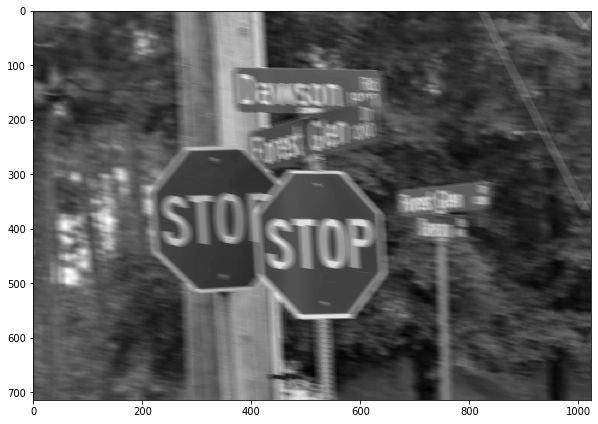

In [2]:
img_blur = cv2.cvtColor(cv2.imread('blur.png'), cv2.COLOR_BGR2GRAY) / 255.0

plt.figure(figsize=(10, 8))
plt.imshow(img_blur, cmap='gray');

Está difícil saber a que altura da rua Forest Glen estamos. Sua equipe está desenvolvendo um primeiro protótipo de um sistema que, a partir desta imagem, gera uma imagem nítida e com perspectiva corrigida de cada uma das placas indicadoras da rua.

Você foi encarregado de fazer uma primeira versão do melhoramento de imagem (*deblurring*, contraste, correção de perspectiva), onde parâmetros essenciais do *deblurring* (tamanho de kernel, orientação, tipo), do contraste e da correção de perspectiva (pontos notáveis) podem ser determinados manualmente. Na sua equipe tem outros engenheiros trabalhando no problema de detectar e segmentar as placas presentes na cena. 

Para facilitar a experimentação:

- O Scikit-Image já tem uma função que faz o filtro de Wiener: ``skimage.restoration.wiener``

- Segue código para fazer um *kernel* de *motion blur* dado o tamanho do kernel, o comprimento do segmento de reta, e o ângulo.

In [3]:
from skimage.restoration import wiener

def make_psf(shape, length, angle):
    psf = np.zeros(shape)
    rows, cols = shape
    center = (cols//2, rows//2)
    psf[center[1], center[0]:(center[0]+length)] = 1.0
    M = cv2.getRotationMatrix2D(center, angle, 1)
    psf = cv2.warpAffine(psf, M, (cols, rows))
    psf = psf / psf.sum()
    return psf

## Tarefa

Escreva um programa que:

- Corrige o *motion blur*
    - Não é necessário neste projeto que o sistema escolha automaticamente os melhores parâmetros para o *deblurring*, determine-os manualmente.

- Melhora o contraste
    - Novamente, se precisar ajustar parâmetros manualmente, tudo bem. Escolha a técnica que quiser para melhoramento de contraste.
    
- Extrai a placa de rua com correção de perspectiva.
    - Os pontos dos cantos da placa não precisam ser determinados automaticamente, escolha manualmente os pontos. A outra parte da sua equipe está trabalhando no outro problema.
    

### Rubrica

- **I**: Entregou algo sem sentido ou muito incompleto (não atinge o nível *D*)

- **D**: Entregou o projeto quase completo, mas faltaram 2 itens dentre os descritos acima.

- **C**: Entregou o projeto quase completo, mas faltou 1 item dentre os descritos acima.

- **B**: Entregou o projeto completo.

- **A**: Entregou o projeto completo e testou alguma técnica mais avançada para resolver o problema do motion-blur. Ver o artigo "Restoration of Motion-Blurred Image Based on Border Deformation Detection: A Traffic Sign Restoration Model", em anexo no Blackboard.

# Blur

In [4]:
def display_mag_freq(img_freq):
    img_freq_aux_mag = np.abs(img_freq)
    img_freq_aux_mag[0,0] = 0.0
    img_freq_aux_mag_display = np.log10(1 + np.fft.fftshift(img_freq_aux_mag))
    plt.figure(figsize=(12,12))
    plt.imshow(img_freq_aux_mag_display, cmap='gray')
    plt.axis('off')
    plt.show()

def faz_gigante(img_blur):
    rows, cols = img_blur.shape
    img_blur_giant = np.zeros((2*rows, 2*cols))
    img_blur_giant[:rows, :cols] = img_blur
    img_blur_giant[:rows, cols:] = img_blur[:, ::-1]
    img_blur_giant[rows:, :cols] = img_blur[::-1, :]
    img_blur_giant[rows:, cols:] = img_blur[::-1, ::-1]
    return img_blur_giant, rows, cols

### Fourrier:
    Na célula abaixo foi feita e plotada a transformada de fourrier da imagem borrada. Essa transformada resulta no plot do domínio da frequência da imagem borrada, com retas horizontais resultantes de traços verticais na imagem (postes, cantos das placas, etc), retas verticais resultantes de traços horizontais da imagem (bordas das placas, bordas da própria imagem, etc) e, por fim, retas diagonais resultantes do restante da imagem.

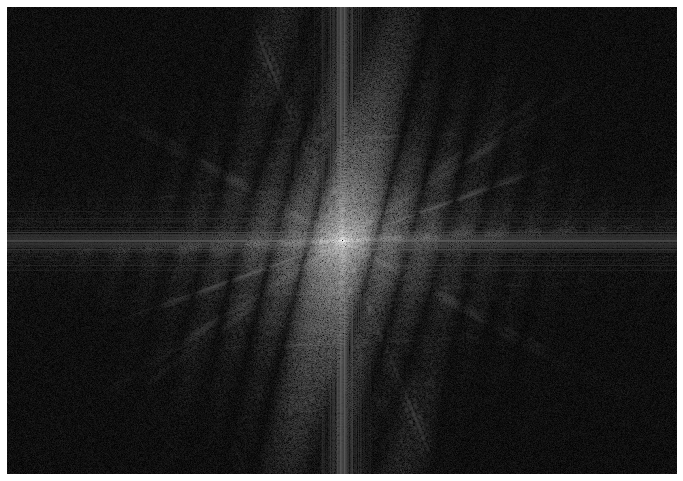

In [5]:
img_freq = np.fft.fft2(img_blur)

display_mag_freq(img_freq)

A partir da imagem gerada na frequência, é possível perceber a existência de um padrão de traços diagonais repetidos, todos com a mesma leve inclinação. Isso é decorrente do borramento e permite a identificação do tipo de kernel utilizado para borrar a imagem original. Através do ângulo das retas periódicas da imagem na frequência, pode-se afirmar que o kernel utlizado foi uma semirreta, com angulação igual à das retas +/- 90°, uma vez que a transformada de fourrier gera uma rotação dos traços da imagem.

### Kernel:
    Agora, o ângulo do kernel foi inferido como aproximadamente -20° (ou +160°), e assim foi criado uma réplica de comprimento ajustado para chegar mais próximo do original. É importante notar que esse kernel foi aplicado em uma imagem criada, com dimensões 2x maiores que a imagem original, resultando em uma com 4x o tamanho. Esse é um truque utilizado para diminuir os efeitos de transições abruptas nas bordas da imagem, as quais resultam em retas pretas quando transformadas de volta do domínio da frequência.

714 1024


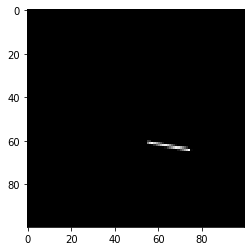

In [6]:
giant_test, rows, cols = faz_gigante(img_blur)

kernel = make_psf(giant_test.shape, 20, 170)

plt.imshow(kernel[650:750, 950:1050], cmap='gray')
print(rows, cols)
plt.show()

### Filtro de Wiener
    Agora, com o kernel em mãos, será aplicado o filtro de Wiener. Esse filtro aplica uma multiplicação, de uma imagem e um kernel, ambos no domínio da frequência. Como utilizamos um kernel aproximado do que foi realmente utilizado, a imagem resultante deve ficar distorcida, uma vez que o pequeno erro é amplificado. Por fim, é aplicada uma transformada inversa de fourrier para trazer de volta do domínio da frequência.

In [7]:
def wiener(G, H, K):
    W = H.conj() / (np.abs(H)**2 + K)
    F = W*G
    return F

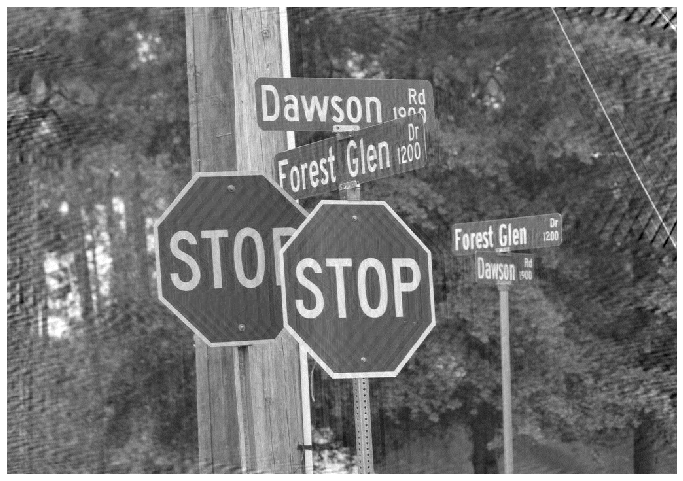

In [8]:
K = 0.0007

h = kernel
H = np.fft.fft2(h)

G = np.fft.fft2(giant_test)
img_test_blur_recon_wiener_freq = wiener(G, H, K)
img_test_blur_recon_wiener = np.fft.fftshift(np.fft.ifft2(img_test_blur_recon_wiener_freq).real)

img_test_blur_recon_wiener_cut = img_test_blur_recon_wiener[:rows, :cols]

plt.figure(figsize=(12,12))
plt.imshow(np.clip(img_test_blur_recon_wiener_cut, 0, 1), cmap='gray')
plt.axis('off')
plt.show()

# Contraste

A seguir, é feito o realce de contraste da imagem, para melhor visualizar seus detales e destacar a placa.

In [9]:
def muda_contraste(img, delta_contraste):
    media = np.mean(img)
    res = delta_contraste * (img - media) + media
    return np.clip(res, 0, 255)

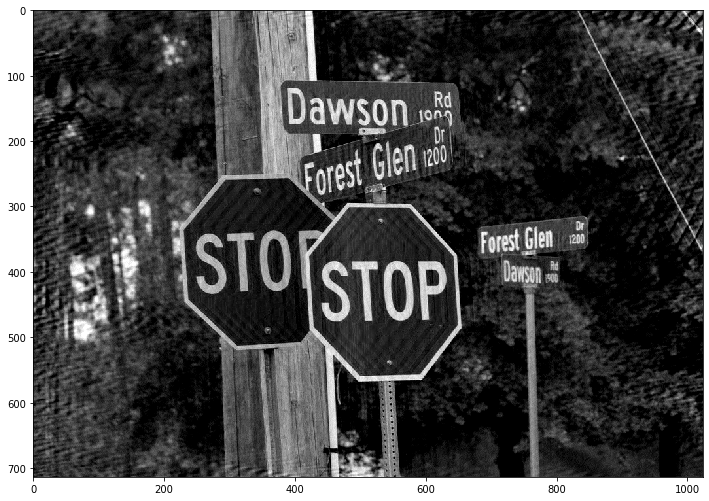

In [10]:
contrastada = muda_contraste(np.clip(img_test_blur_recon_wiener_cut, 0, 1), 3)

plt.figure(figsize=(12,12))
plt.imshow(contrastada, cmap="gray")
plt.show()

# Perspectiva

Agora, para a correção de perspectiva da placa, foram selecionados seus quatro cantos manualmente, para serem inseridos na função de correção.

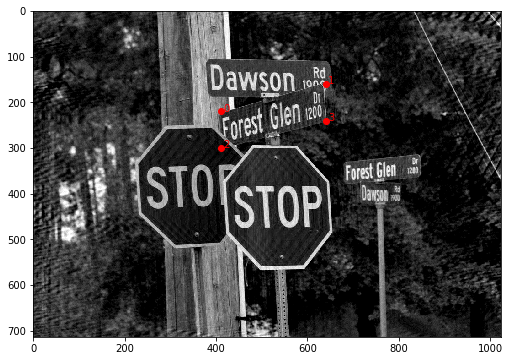

In [11]:
rows_pers, cols_pers = (256, 1024)

pts_original = np.float32([[410,220],[640,160],[410,300],[640,240]])
pts_corrigida = np.float32([[0, 0], [cols_pers - 1, 0], [0, rows_pers - 1], [cols_pers - 1, rows_pers - 1]])

plt.figure(figsize=(12,6))
plt.imshow(contrastada, cmap='gray')
for k, p in enumerate(pts_original):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')

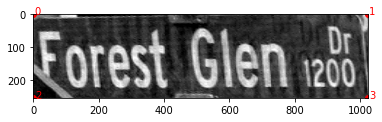

In [12]:
M = cv2.getPerspectiveTransform(pts_original, pts_corrigida)

img_corrigida = cv2.warpPerspective(contrastada, M, (cols_pers, rows_pers))

plt.imshow(img_corrigida, cmap='gray')
for k, p in enumerate(pts_corrigida):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')
plt.show()